In [1]:
import pandas as pd

# Load your data (assuming it's in a variable named 'df')
df = pd.read_csv('/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/glm_runs/lsa_wfdelay/64kDense/sub-01/_reliability_roi_wfdelay/split_half_roi_reliability_fisherz.tsv', sep='\t')

# 1. Define your target ROIs
target_rois = ['8BM', '8Av', '8Ad', '8BL', '8C', '9m', '9p', '9a', '9-46d', 'a9-46v', 'p9-46v', '46', '47l', '47m', '47s', 'a47r', 'p47r', '10r', '10d', '10v', 'a10p', 'p10p', '10pp', '11l']

# 2. Filter for Task 'ctxdm' and Phase 'Delay'
# We look for rows where task is 'ctxdm' AND phase is 'Delay'
subset = df[
    (df['phase'] == 'Delay')
].copy()

# 3. Filter for the specific ROIs
# This lambda function checks if any of your target ROI strings (e.g., "46") 
# appear inside the full ROI name (e.g., "L_46_ROI+R_46_ROI")
subset = subset[subset['roi'].apply(lambda x: any(t in x for t in target_rois))]

# 4. Group by ROI and calculate the average Noise Ceiling
# We reset_index to make it a pretty dataframe
avg_noise_ceilings = subset.groupby('roi')['noise_ceiling'].mean().reset_index()

print(avg_noise_ceilings[avg_noise_ceilings['noise_ceiling'] > 0.5])

                          roi  noise_ceiling
3         L_10v_ROI+R_10v_ROI       0.572003
5           L_46_ROI+R_46_ROI       0.516387
11        L_8BL_ROI+R_8BL_ROI       0.635041
13          L_8C_ROI+R_8C_ROI       0.681234
14    L_9-46d_ROI+R_9-46d_ROI       0.654331
23  L_p9-46v_ROI+R_p9-46v_ROI       0.581136


True Betas Shape: (474, 1)
Pred Betas Shape: (51200, 1)


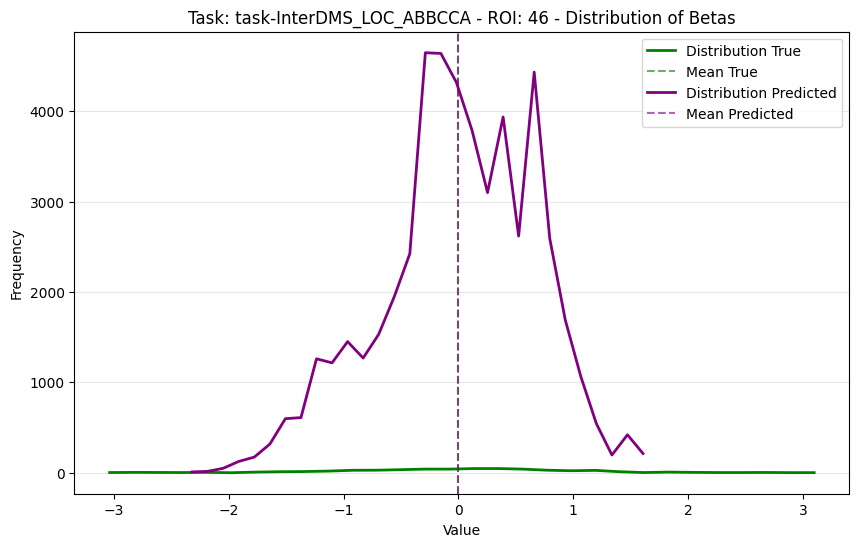

In [11]:
import matplotlib.pyplot as plt
import numpy as np

region = '46'
ctrl_task = 'task-InterDMS_LOC_ABBCCA'

true_betas = np.load('/mnt/store1/lucas/checkpoints/fixed/tf_medium_full_3000eps_ubt_semifixed/results/frame-only_enc+delay_delay_lsa_wfdelay/betas.npz')
pred_betas = np.load(f'/mnt/store1/lucas/checkpoints/fixed/tf_medium_full_3000eps_ubt_semifixed/results/ctrl_pred_betas/LH_RH/{ctrl_task}/results.npz')

roi_tb = true_betas[region]
roi_pb = pred_betas[region]

# Reshape roi_pb 
n_trials = roi_pb.shape[0]
n_delays = roi_pb.shape[1]  
roi_pb = roi_pb.reshape(n_trials*n_delays, roi_pb.shape[2])

print(f"True Betas Shape: {roi_tb.shape}"
      f"\nPred Betas Shape: {roi_pb.shape}")

def get_freq_poly(data, bins=30):
    # Calculate histogram counts and bin edges
    counts, bin_edges = np.histogram(data, bins=bins)
    # Calculate midpoints of the bins for the line plot
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, counts

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot Distribution 1
roi_tb_centers, roi_tb_counts = get_freq_poly(roi_tb)
plt.plot(roi_tb_centers, roi_tb_counts, label='Distribution True', color='green', linewidth=2)
plt.axvline(roi_tb.mean(), color='green', linestyle='--', alpha=0.6, label='Mean True')

# Plot Distribution 2
roi_pb_centers, roi_pb_counts = get_freq_poly(roi_pb)
plt.plot(roi_pb_centers, roi_pb_counts, label='Distribution Predicted', color='purple', linewidth=2)
plt.axvline(roi_pb.mean(), color='purple', linestyle='--', alpha=0.6, label='Mean Predicted')

# Formatting
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title(f"Task: {ctrl_task} - ROI: {region} - Distribution of Betas")
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

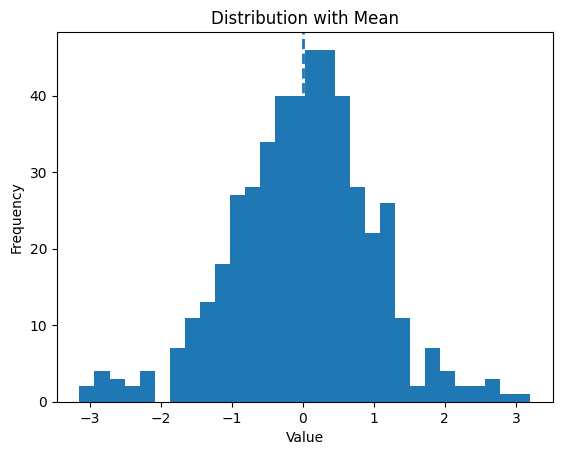

In [ ]:
import numpy as np
data = np.load('/mnt/store1/lucas/checkpoints/fixed/tf_medium_full_3000eps_ubt_semifixed/results/frame-only_enc+delay_delay_lsa_wfdelay/betas.npz')

import matplotlib.pyplot as plt

x = np.mean(data['46'], axis=1)

x = x.squeeze()                 

# compute stats
mean = x.mean()

# plot histogram
plt.figure()
plt.hist(x, bins=30, density=False)

# mean line
plt.axvline(mean, linestyle='--', linewidth=2)

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution with Mean")

plt.show()



In [ ]:
data = np.load('/mnt/store1/lucas/checkpoints/fixed/tf_medium_full_3000eps_ubt_semifixed/results/test_ctrl/test_infer/results.npz')

data['46'].reshape()

(512, 2, 1)

Wrote: /mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/glm_runs/lsa_wofdelay/64kDense/sub-01/_reliability_roi_wofdelay/roi_noise_ceiling_bars.png


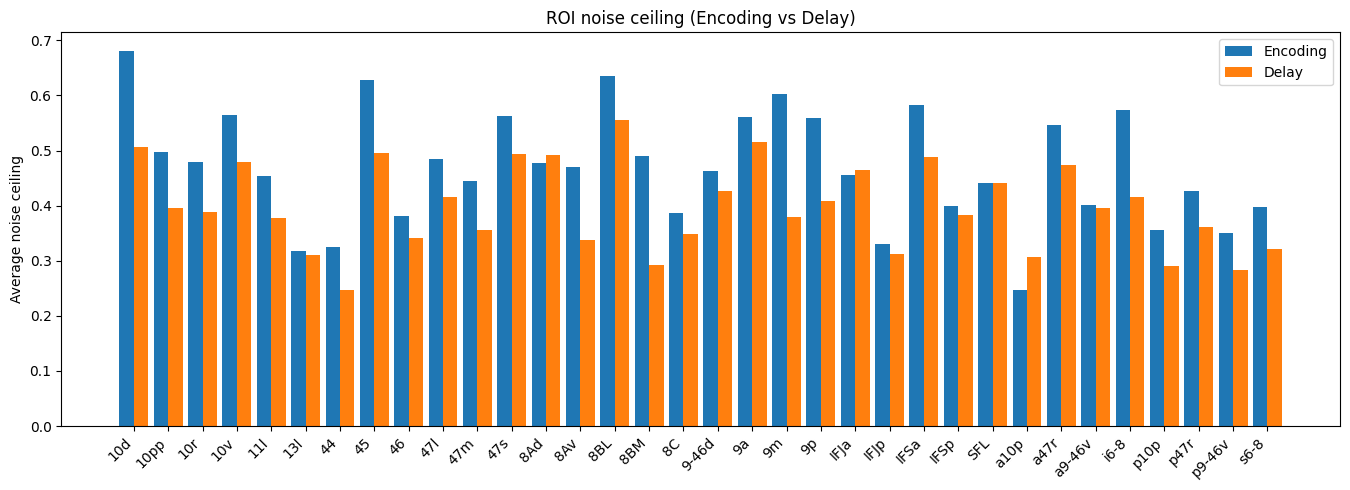

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

tsv = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/glm_runs/lsa_wofdelay/64kDense/sub-01/_reliability_roi_wofdelay/split_half_roi_reliability_fisherz.tsv"
out_png = os.path.join(os.path.dirname(tsv), "roi_noise_ceiling_bars.png")

df = pd.read_csv(tsv, sep="\t")

# Sanity check
need = {"roi", "phase", "noise_ceiling"}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"TSV is missing columns: {missing}")

# -------------------------------------------------
# Clean ROI labels
# -------------------------------------------------
def clean_roi_label(roi: str) -> str:
    """
    Examples:
      L_V1_ROI+R_V1_ROI -> V1
      L_46_ROI+R_46_ROI -> 46
      L_V4_ROI         -> V4
    """
    parts = roi.split("+")
    cleaned = []
    for p in parts:
        p = re.sub(r"^[LR]_", "", p)     # drop L_ / R_
        p = re.sub(r"_ROI$", "", p)      # drop _ROI
        cleaned.append(p)
    # If bilateral, both sides should now be identical
    return cleaned[0]

df["roi_clean"] = df["roi"].apply(clean_roi_label)

# -------------------------------------------------
# Aggregate: mean noise ceiling per ROI × phase
# -------------------------------------------------
g = (
    df.groupby(["roi_clean", "phase"], as_index=False)["noise_ceiling"]
      .mean()
)

roi_order = sorted(g["roi_clean"].unique())
phases = ["Encoding", "Delay"]

pivot = (
    g.pivot(index="roi_clean", columns="phase", values="noise_ceiling")
     .reindex(index=roi_order, columns=phases)
)

# -------------------------------------------------
# Plot (grouped bars)
# -------------------------------------------------
x = np.arange(len(pivot.index))
width = 0.42

fig_w = max(8, 0.4 * len(pivot.index))
plt.figure(figsize=(fig_w, 5))

plt.bar(x - width/2, pivot["Encoding"], width, label="Encoding")
plt.bar(x + width/2, pivot["Delay"], width, label="Delay")

plt.xticks(x, pivot.index, rotation=45, ha="right")
# set yticks from 0.0 to 0.8
plt.yticks(np.arange(0.0,0.8, 0.1))
plt.ylabel("Average noise ceiling")
plt.title("ROI noise ceiling (Encoding vs Delay)")
plt.legend()

plt.tight_layout()
plt.savefig(out_png, dpi=200)
print("Wrote:", out_png)
plt.show()

In [5]:
import pandas as pd

tsv = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/glm_runs/lss/64kDense/sub-01/_reliability_roi/split_half_roi_reliability_fisherz_pfc.tsv"
df = pd.read_csv(tsv, sep="\t")

required_cols = ["roi", "phase", "r_mean", "r_sb_mean", "noise_ceiling"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

cols = ["r_mean", "r_sb_mean", "noise_ceiling"]

# 1) Average within ROI × phase (handles duplicates / multiple taskdirs per ROI)
roi_phase_means = (
    df.groupby(["roi", "phase"], as_index=False)[cols]
      .mean()
)

# 2) Average across ROIs, separately for Encoding and Delay
phase_means_across_rois = (
    roi_phase_means.groupby("phase")[cols]
                   .mean()
                   .round(4)
)

print("\nMean values by phase (averaged across ROIs):")
print(phase_means_across_rois)

# Optional: overall mean across phases (simple average of the two phase rows)
overall = phase_means_across_rois.mean().round(4)
print("\nOverall mean (Encoding + Delay):")
print(overall)


Mean values by phase (averaged across ROIs):
          r_mean  r_sb_mean  noise_ceiling
phase                                     
Delay     0.1070     0.0765         0.3625
Encoding  0.1516     0.1987         0.4286

Overall mean (Encoding + Delay):
r_mean           0.1293
r_sb_mean        0.1376
noise_ceiling    0.3955
dtype: float64


In [ ]:
import nibabel as nib

dlabel_path = "/home/lucas/projects/MULTFSCTRL/prep/fmriprep/Glasser_LR_Dense64k.dlabel.nii"

dl = nib.load(dlabel_path)
label_dict = dl.header.get_axis(0).label[0]

for k, (name, rgba) in sorted(label_dict.items()):
    print(f"{k:4d}  {name}")

names = ['SFL', 'i6-8', 's6-8', 'IFJa', 'IFJp', 'IFSp', 'IFSa', '8BM', '8Av', '8Ad', '8BL', 
         '8C', '9m', '9p', '9a', '9-46d', 'a9-46v', 'p9-46v', '46', '44', '45', '47l', '47m', 
         '47s', 'a47r', 'p47r', '10r', '10d', '10v', 'a10p', 'p10p', '10pp', '11l', '13l']

roi_names = [['L_' + n + '_ROI', 'R_' + n + '_ROI' ] for n in names] 
if not roi_set:
    raise ValueError("roi_names is empty after parsing.")

for name in roi_names:
    if name not in {n for _, (n, _) in label_dict.items()}:
        raise ValueError(f"ROI name '{name}' not found in label dictionary.")

keys = [k for k, (name, _) in label_dict.items() if name in roi_set]
found = [label_dict[k][0] for k in keys]

print(len(found) == len(roi_set))  # Should be True

   0  ???
   1  L_V1_ROI
   2  L_MST_ROI
   3  L_V6_ROI
   4  L_V2_ROI
   5  L_V3_ROI
   6  L_V4_ROI
   7  L_V8_ROI
   8  L_4_ROI
   9  L_3b_ROI
  10  L_FEF_ROI
  11  L_PEF_ROI
  12  L_55b_ROI
  13  L_V3A_ROI
  14  L_RSC_ROI
  15  L_POS2_ROI
  16  L_V7_ROI
  17  L_IPS1_ROI
  18  L_FFC_ROI
  19  L_V3B_ROI
  20  L_LO1_ROI
  21  L_LO2_ROI
  22  L_PIT_ROI
  23  L_MT_ROI
  24  L_A1_ROI
  25  L_PSL_ROI
  26  L_SFL_ROI
  27  L_PCV_ROI
  28  L_STV_ROI
  29  L_7Pm_ROI
  30  L_7m_ROI
  31  L_POS1_ROI
  32  L_23d_ROI
  33  L_v23ab_ROI
  34  L_d23ab_ROI
  35  L_31pv_ROI
  36  L_5m_ROI
  37  L_5mv_ROI
  38  L_23c_ROI
  39  L_5L_ROI
  40  L_24dd_ROI
  41  L_24dv_ROI
  42  L_7AL_ROI
  43  L_SCEF_ROI
  44  L_6ma_ROI
  45  L_7Am_ROI
  46  L_7PL_ROI
  47  L_7PC_ROI
  48  L_LIPv_ROI
  49  L_VIP_ROI
  50  L_MIP_ROI
  51  L_1_ROI
  52  L_2_ROI
  53  L_3a_ROI
  54  L_6d_ROI
  55  L_6mp_ROI
  56  L_6v_ROI
  57  L_p24pr_ROI
  58  L_33pr_ROI
  59  L_a24pr_ROI
  60  L_p32pr_ROI
  61  L_a24_ROI
  62  L_d32_ROI
 

AttributeError: 'list' object has no attribute 'strip'

In [ ]:
import nibabel as nib
import numpy as np

# ---- paths ----
dscalar_path = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/glm_runs/lss/64kDense/sub-01/ses-01/task-ctxdm_acq-col_run-01/task-ctxdm_col_run-01_lss-DelayTarget_Del0001_events_beta-target.dscalar.nii"
dtseries_path = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/64kDense/sub-01/ses-01/sub-01_ses-01_task-ctxdm_acq-col_run-01_space-Glasser64k_bold.dtseries.nii"

# ---- load files ----
beta_img = nib.load(dscalar_path)
dt_img = nib.load(dtseries_path)

beta = beta_img.get_fdata()        # shape: (1, n_vertices)
beta = beta.squeeze()              # shape: (n_vertices,)

# ---- basic checks ----
print("Beta shape:", beta.shape)
print("Expected vertices:", len(dt_img.header.get_axis(1)))

assert beta.ndim == 1, "Beta is not 1D"
assert beta.shape[0] == len(dt_img.header.get_axis(1)), "Vertex count mismatch"

# ---- value checks ----
print("NaNs:", np.isnan(beta).sum())
print("Infs:", np.isinf(beta).sum())

print("Min:", beta.min())
print("Max:", beta.max())
print("Mean:", beta.mean())
print("Std:", beta.std())

# ---- quick percentiles ----
for p in [1, 5, 25, 50, 75, 95, 99]:
    print(f"P{p:02d}:", np.percentile(beta, p))

print("\nSanity check passed.")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn.glm.first_level import make_first_level_design_matrix
from matplotlib.lines import Line2D


TR = 1.49

events_tsv = "/mnt/tempdata/lucas/fmri/recordings/TR/behav/sub-01/ses-1/events/task-ctxdm_col_run-01_LSS/task-ctxdm_col_run-01_lss-EncTarget_Enc0001_events.tsv"   # one LSS events file
confounds_tsv = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/confounds/sub-01/ses-01/sub-01_ses-01_task-ctxdm_acq-col_run-01_desc-confounds_timeseries.tsv"

hrf_model = "glover"
high_pass = 0.01  # Hz
confound_cols = ["trans_x","trans_y","trans_z","rot_x","rot_y","rot_z"]
add_fd = True

# window around target (seconds)
pre_s = 20.0
post_s = 40.0


# ---------- load ----------
events = pd.read_csv(events_tsv, sep="\t")[["onset","duration","trial_type"]].copy()
conf = pd.read_csv(confounds_tsv, sep="\t")

cols = confound_cols.copy()
if add_fd and "framewise_displacement" in conf.columns:
    cols.append("framewise_displacement")
confounds = conf[cols].fillna(0.0)

n_scans = confounds.shape[0]
frame_times = np.arange(n_scans) * TR

# ---------- design matrix ----------
X = make_first_level_design_matrix(
    frame_times=frame_times,
    events=events,
    hrf_model=hrf_model,
    drift_model="cosine",
    high_pass=high_pass,
    add_regs=confounds.to_numpy(),
    add_reg_names=cols,
)

# ---------- find target event ----------
target_rows = events[events["trial_type"].str.contains("Target", case=False, na=False)]
if len(target_rows) != 1:
    raise ValueError(f"Expected exactly one Target row in LSS events file, found {len(target_rows)}")

target_onset = float(target_rows.iloc[0]["onset"])
target_duration = float(target_rows.iloc[0]["duration"])
target_offset = target_onset + target_duration
target_type = target_rows.iloc[0]["trial_type"]

# ---------- compute window indices ----------
t0 = max(0.0, target_onset - pre_s)
t1 = min(frame_times[-1], target_onset + post_s)

win_mask = (frame_times >= t0) & (frame_times <= t1)
t_win = frame_times[win_mask]

# ---------- choose columns to plot ----------
task_cols = [c for c in X.columns if any(k in c for k in
                                        ["EncTarget","EncOther","EncAll",
                                         "DelayTarget","DelayOther","DelayAll"])]

# optionally include confounds in the zoom view
conf_cols = [c for c in X.columns if c in cols]

# ---------- onset/offset markers in window ----------
enc_events = events[events["trial_type"].str.contains("Enc", case=False, na=False)]
enc_onsets = enc_events["onset"].to_numpy()
enc_offsets = (enc_events["onset"] + enc_events["duration"]).to_numpy()

delay_events = events[events["trial_type"].str.contains("Delay", case=False, na=False)]
delay_onsets = delay_events["onset"].to_numpy()  # these are stimulus offsets / delay onsets

# keep only markers inside window
enc_onsets = enc_onsets[(enc_onsets >= t0) & (enc_onsets <= t1)]
delay_onsets = delay_onsets[(delay_onsets >= t0) & (delay_onsets <= t1)]
enc_offsets = enc_offsets[(enc_offsets >= t0) & (enc_offsets <= t1)]


# ---------- plot: zoomed task regressors ----------
plt.figure(figsize=(12, 5))

for c in task_cols:
    plt.plot(t_win, X.loc[win_mask, c].values, label=c)

# mark encoding onsets (dashed) and delay onsets / stimulus offsets (dotted)
for x in enc_onsets:
    plt.axvline(x, linestyle="--", linewidth=0.8, alpha=0.6)
for x in delay_onsets:
    plt.axvline(x, linestyle=":", linewidth=0.9, alpha=0.6)

# highlight target onset (thicker solid) + shade its duration
plt.axvline(target_onset, linestyle="-", linewidth=2.0, alpha=0.9)
plt.axvspan(target_onset, target_offset, alpha=0.12)

# add legend entries for markers
handles, labels = plt.gca().get_legend_handles_labels()
handles += [
    Line2D([0],[0], linestyle="-", color="k", linewidth=2, label=f"Target onset ({target_type})"),
    Line2D([0],[0], linestyle="--", color="k", linewidth=1, label="Encoding onset"),
    Line2D([0],[0], linestyle=":", color="k", linewidth=1, label="Stimulus offset / Delay onset"),
]
labels += [f"Target onset ({target_type})", "Encoding onset", "Stimulus offset / Delay onset"]

plt.xlabel("Time (s)")
plt.ylabel("Regressor value (HRF-convolved)")
plt.title(f"Zoomed LSS regressors around target: {t0:.1f}s to {t1:.1f}s")
plt.legend(handles, labels, fontsize=8, loc="upper right")
plt.tight_layout()
plt.show()


# ---------- optional: zoomed confounds ----------
plt.figure(figsize=(12, 4))
for c in conf_cols:
    plt.plot(t_win, X.loc[win_mask, c].values, label=c)
plt.axvline(target_onset, linestyle="-", linewidth=2.0, alpha=0.9)
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Zoomed confounds around target")
plt.legend(fontsize=8, loc="upper right")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.glm.first_level import make_first_level_design_matrix

TR = 1.49

# paths
dtseries_path = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/64kDense/sub-01/ses-01/sub-01_ses-01_task-ctxdm_acq-col_run-01_space-Glasser64k_bold.dtseries.nii"
events_tsv = "/mnt/tempdata/lucas/fmri/recordings/TR/behav/sub-01/ses-1/events/task-ctxdm_col_run-01_LSS/task-ctxdm_col_run-01_lss-EncTarget_Enc0001_events.tsv"   # one LSS events file
confounds_tsv = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/confounds/sub-01/ses-01/sub-01_ses-01_task-ctxdm_acq-col_run-01_desc-confounds_timeseries.tsv"
beta_dscalar = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/glm_runs/lss/64kDense/sub-01/ses-01/task-ctxdm_acq-col_run-01/task-ctxdm_col_run-01_lss-EncTarget_Enc0001_events_beta-target.dscalar.nii"

# pick a vertex index (try a few!)
vertex = 24353

# load data
dt = nib.load(dtseries_path)
Y = dt.get_fdata().astype(float)
Y = Y if Y.shape[0] < Y.shape[1] else Y.T   # ensure (time, vertex)

beta = nib.load(beta_dscalar).get_fdata().squeeze()

events = pd.read_csv(events_tsv, sep="\t")
conf = pd.read_csv(confounds_tsv, sep="\t").fillna(0)

frame_times = np.arange(Y.shape[0]) * TR

# build design matrix (must match GLM)
X = make_first_level_design_matrix(
    frame_times,
    events,
    hrf_model="glover",
    drift_model="cosine",
    high_pass=0.01,
    add_regs=conf[[
        "trans_x","trans_y","trans_z",
        "rot_x","rot_y","rot_z"
    ]].values,
    add_reg_names=[
        "trans_x","trans_y","trans_z",
        "rot_x","rot_y","rot_z"
    ]
)

# find target regressor
target_col = [c for c in X.columns if "EncTarget" in c or "DelayTarget" in c][0]

# fitted target contribution
yhat_target = X[target_col].values * beta[vertex]

# observed data (z-scored version recommended)
y_obs = Y[:, vertex]

# plot
plt.figure(figsize=(10,4))
plt.plot(frame_times, y_obs, color="gray", alpha=0.4, label="Observed BOLD")
plt.plot(frame_times, yhat_target, color="red", linewidth=2, label="Target fitted response")
plt.axvline(events.loc[events.trial_type.str.contains("Target"),"onset"].iloc[0],
            linestyle="--", color="black")
plt.xlim(0, frame_times[-1])
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.legend()
plt.title(f"LSS target fit at vertex {vertex}")
plt.tight_layout()
plt.show()